<a href="https://colab.research.google.com/github/youngchul-sung/three-minutes-keras/blob/master/ex5_2_lstm_airplane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from tensorflow.keras import models, layers
import seaborn as sns

TensorFlow 2.x selected.


In [0]:
def save_history_history(fname, history_history, fold=''):
    np.save(os.path.join(fold, fname), history_history)


def load_history_history(fname, fold=''):
    history_history = np.load(os.path.join(fold, fname)).item(0)
    return history_history


def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_acc(history)
    plt.subplot(1, 2, 2)
    plot_loss(history)


def plot_loss_acc(history):
    plot_loss(history, '(a) Loss trajectory')
    plt.show()
    plot_acc(history, '(b) Accracy trajectory')
    plt.show()


def plot_acc_loss(history):
    plot_acc(history, '(a) Accracy trajectory')
    plt.show()
    plot_loss(history, '(b) Loss trajectory')
    plt.show()

In [3]:
!curl -o international-airline-passengers.csv https://raw.githubusercontent.com/jskDr/keraspp/master/international-airline-passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2334  100  2334    0     0  32416      0 --:--:-- --:--:-- --:--:-- 32416


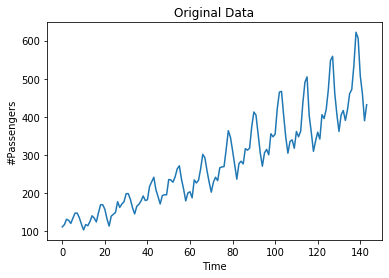

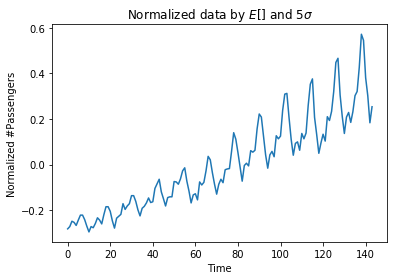

(131, 12, 1) (131,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


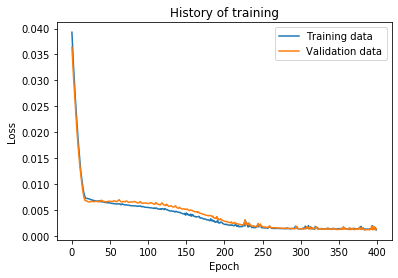

27/27 [==============================] - 0s 109us/sample - loss: 0.0015
Loss: 0.0014624932082369924


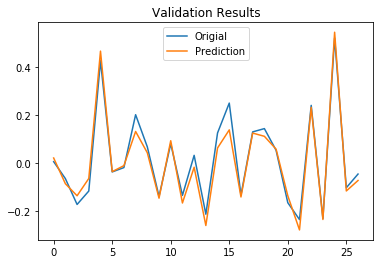

27/27 [==============================] - 0s 91us/sample - loss: 0.0015
Loss: 0.0014624932082369924
(27,) (27,)


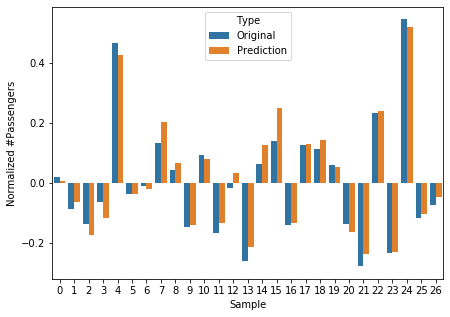

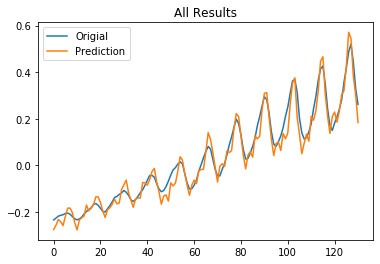

In [4]:
def load_data(fname='international-airline-passengers.csv'):
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)
    data = dataset.values.reshape(-1)
    plt.plot(data)
    plt.xlabel('Time'); plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()

    # data normalize
    data_dn = (data - np.mean(data)) / np.std(data) / 5
    plt.plot(data_dn)
    plt.xlabel('Time'); plt.ylabel('Normalized #Passengers')
    plt.title('Normalized data by $E[]$ and $5\sigma$')
    plt.show()
    
    return data_dn


def get_Xy(data, D=12):
    # make X and y
    X_l = []
    y_l = []
    N = len(data)
    assert N > D, "N should be larger than D, where N is len(data)"
    for ii in range(N-D-1):
        X_l.append(data[ii:ii+D])
        y_l.append(data[ii+D])
    X = np.array(X_l)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_l)
    print(X.shape, y.shape)
    return X, y


class Dataset:
    def __init__(self, fname='international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        X, y = get_Xy(data_dn, D=D)
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)  
        
        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test


def rnn_model(shape):
    m_x = layers.Input(shape=shape) #X.shape[1:]
    m_h = layers.LSTM(10)(m_x)
    m_y = layers.Dense(1)(m_h)
    m = models.Model(m_x, m_y)
    
    m.compile('adam', 'mean_squared_error')
    
    m.summary()
    
    return m


class Machine():
    def __init__(self):
        self.data = Dataset()
        shape = self.data.X.shape[1:]
        self.model = rnn_model(shape)
        
    def run(self, epochs=400):
        d = self.data
        X_train, X_test, y_train, y_test = d.X_train, d.X_test, d.y_train, d.y_test
        X, y = d.X, d.y
        m = self.model 
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)

        plot_loss(h)
        plt.title('History of training')
        plt.show()

        yp = m.predict(X_test)
        print('Loss:', m.evaluate(X_test, y_test))
        plt.plot(yp, label='Origial')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()

        yp = m.predict(X_test).reshape(-1)
        print('Loss:', m.evaluate(X_test, y_test))  
        print(yp.shape, y_test.shape)

        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['Prediction'] * len(yp)

        plt.figure(figsize=(7, 5))
        sns.barplot(x="Sample", y="Normalized #Passengers", 
                    hue="Type", data=df)
        plt.ylabel('Normalized #Passengers')
        plt.show()
        
        yp = m.predict(X)

        plt.plot(yp, label='Origial')
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()


def main():        
    machine = Machine() 
    machine.run(epochs=400)


if __name__ == '__main__':
    main()